<div style="background-color:#fae1dd;">
    <center><img src="https://i.imgur.com/Kbl1z3a.gif"></center>
    <br><br>
    <h3><center>Diabetes Mellitus Prediction</center></h3>
    <center><img src="https://2018.igem.org/wiki/images/f/f8/T--HAFS--Project_Description_pt1.gif"></center>
</div>

<div style="background-color:#fae1dd; color:black;">
    <h3><center>Introduction 📝</center></h3>
</div>

> 🎯Goal: To determine whether a patient admitted to an ICU has been diagnosed Diabetes Mellitus

> WiDS Datathon 2021, includes several patient records from the first 24 hours of intensive care, and we are required to determine whether a patient admitted to an ICU has been diagnosed with a particular type of diabetes, Diabetes Mellitus. 

> The tabular data contains 181 columns, making Exploratory Data Analysis a crucial step to spot patterns and special cases and pick the columns that create a statistically significant difference in model performance. Libraries that are tailored to run on the CPU tend to become a bottleneck in terms of memory usage and time with larger datasets. 
> - [Competition data](https://www.kaggle.com/c/widsdatathon2021/data)
> - [Competition notebook](https://www.kaggle.com/ruchi798/wids-datathon-2021-rapids-xgb-lightgbm) 

<div style="background-color:#fae1dd; color:black;">
    <h3><center>Importing Libraries📚</center></h3>
</div>

In [2]:
!pip install pywaffle
!pip install pycomp

import numpy as np 
import pandas as pd 
import os
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import cudf
import cuml
import shap
import xgboost

from pywaffle import Waffle
from pycomp.viz.insights import *

from cuml.preprocessing.TargetEncoder import TargetEncoder
from cuml.linear_model import Ridge
from cuml.svm import SVR
from cuml.neighbors import KNeighborsClassifier
from cuml.metrics import accuracy_score,roc_auc_score as ras
from cuml.preprocessing.model_selection import train_test_split

from lightgbm import LGBMClassifier

from sklearn.metrics import roc_auc_score,roc_curve,auc
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, precision_recall_curve
from scipy import interp

import warnings
import time
warnings.filterwarnings("ignore")

     |████████████████████████████████| 526 kB 1.2 MB/s 
     |████████████████████████████████| 52 kB 519 kB/s 
     |████████████████████████████████| 12.4 MB 10.9 MB/s 
     |████████████████████████████████| 294 kB 21.7 MB/s 
     |████████████████████████████████| 326 kB 22.5 MB/s 
     |████████████████████████████████| 215 kB 23.3 MB/s 
     |████████████████████████████████| 6.8 MB 23.1 MB/s 
     |████████████████████████████████| 20.1 MB 40.3 MB/s 
  Created wheel for shap: filename=shap-0.37.0-cp37-cp37m-linux_x86_64.whl size=468626 sha256=0b3f82bb34dafe9e42d8922c35ad3e97e019d4bf4aa6c938a2d41bf26a1f702d
  Stored in directory: /root/.cache/pip/wheels/df/b8/18/2c0a6105152e62dd9a7cf47b5110b9cedb0c8739babdef64b7
Successfully built shap
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: joblib
    Found existing installation: joblib 1.0.0
    Uninstalling jo

In [3]:
!nvidia-smi

Tue Mar 23 09:39:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    33W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Wed_Oct_23_19:24:38_PDT_2019
Cuda compilation tools, release 10.2, V10.2.89


In [5]:
def custom_palette(custom_colors):
    customPalette = sns.set_palette(sns.color_palette(custom_colors))
    sns.palplot(sns.color_palette(custom_colors),size=0.8)
    plt.tick_params(axis='both', labelsize=0, length = 0)

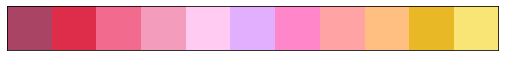

In [6]:
#defining colour palette
red = ["#4f000b","#720026","#ce4257","#ff7f51","#ff9b54"]
bo = ["#6930c3","#5e60ce","#0096c7","#48cae4","#ade8f4","#ff7f51","#ff9b54","#ffbf69"]
pink = ["#aa4465","#dd2d4a","#f26a8d","#f49cbb","#ffcbf2","#e2afff","#ff86c8","#ffa3a5","#ffbf81","#e9b827","#f9e576"]
custom_palette(pink)

In [7]:
#set context to customize and style plots
sns.set_context("poster", font_scale = 0.6, rc={"grid.linewidth": 0.4})

#set font family
sns.set_style({'font.family':'serif'})

In [8]:
#reading csv files
train_df =  pd.read_csv("../input/widsdatathon2021/TrainingWiDS2021.csv")
test_df = pd.read_csv("../input/widsdatathon2021/UnlabeledWiDS2021.csv")
data_dictionary = pd.read_csv("../input/widsdatathon2021/DataDictionaryWiDS2021.csv")

<div style="background-color:#fae1dd; color:black;">
    <h3><center>Data Dictionary</center></h3>
    <h4><center>Supplemental information about the data</center></h4>
</div>

In [9]:
fig = go.Figure(data=[go.Table(
    header=dict(values=list(data_dictionary.columns),
                fill_color=pink[2],
                line_color='black',
                align='center'),
    cells=dict(values=[data_dictionary.Category,data_dictionary['Variable Name'],data_dictionary['Unit of Measure'],data_dictionary['Data Type'],data_dictionary['Description'],data_dictionary['Example']],
               fill_color=pink[4],
               line_color='black',
               align='left'))
])

fig.show()

<p><mark>Let's take a look at the training data!</mark></p>

In [10]:
train_df.head(10)

Unnamed: 0  encounter_id  hospital_id   age        bmi  elective_surgery  \
0           1        214826          118  68.0  22.732803                 0   
1           2        246060           81  77.0  27.421875                 0   
2           3        276985          118  25.0  31.952749                 0   
3           4        262220          118  81.0  22.635548                 1   
4           5        201746           33  19.0        NaN                 0   
5           6        182697           83  67.0  27.555611                 0   
6           7        195124           83  59.0  57.451002                 0   
7           8        179261           33  70.0        NaN                 0   
8           9        271041          118  45.0        NaN                 0   
9          10        238874          118  50.0  25.707702                 0   

   ethnicity gender  height hospital_admit_source  ... h1_pao2fio2ratio_max  \
0  Caucasian      M   180.3                 Floor  ...                  NaN   
1  Caucasian      F   160.0                 Floor  ...                 51.0   
2  Caucasian      F   172.7  Emergency Department  ...                  NaN   
3  Caucasian      F   165.1        Operating Room  ...                337.0   
4  Caucasian      M   188.0                   NaN  ...                  NaN   
5  Caucasian      M   190.5          Direct Admit  ...                  NaN   
6  Caucasian      F   165.1        Operating Room  ...                370.0   
7  Caucasian      M   165.0  Emergency Department  ...                  NaN   
8  Caucasian      M   170.2        Other Hospital  ...                 92.0   
9        NaN      M   175.3          Direct Admit  ...                  NaN   

   h1_pao2fio2ratio_min aids cirrhosis  hepatic_failure  immunosuppression  \
0                   NaN    0         0                0                  0   
1                  51.0    0         0                0                  0   
2                   NaN    0         0                0                  0   
3                 337.0    0         0                0                  0   
4                   NaN    0         0                0                  0   
5                   NaN    0         0                0                  0   
6                 370.0    0         0                0                  0   
7                   NaN    0         0                0                  1   
8                  92.0    0         0                0                  0   
9                   NaN    0         0                0                  0   

   leukemia  lymphoma  solid_tumor_with_metastasis  diabetes_mellitus  
0         0         0                            0                  1  
1         0         0                            0                  1  
2         0         0                            0                  0  
3         0         0                            0                  0  
4         0         0                            0                  0  
5         0         0                            0                  1  
6         0         0                            0                  1  
7         0         0                            0                  0  
8         0         0                            0                  0  
9         0         0                            0                  0  

[10 rows x 181 columns]

<p><mark>We can drop the Unnamed:0 column.</mark></p>

In [11]:
train_df = train_df.drop(columns=['Unnamed: 0'])
test_df = test_df.drop(columns=['Unnamed: 0'])

<p><mark>Now let's see the descriptive statistics for this dataframe.</mark></p>

In [12]:
train_df.describe().T.style

<p><mark>There seems to be a mismatch in the number of values per column, we definitely have many missing values.</mark></p>


In [13]:
missing_count = train_df.isna().sum()
missing_df = (pd.concat([missing_count.rename('Missing count'),
                     missing_count.div(len(train_df))
                          .rename('Missing ratio')],axis = 1)
             .loc[missing_count.ne(0)])

#color the background of cells in a dataframe depending on the value of the data in each column 
missing_df.style.background_gradient(cmap="cool")

<p><mark>We need to analyse the distribution of values before we fill in the missing values.</mark></p>

In [14]:
dt_i=[]
dt_fl=[]
dt_o=[]

#making a list of columns depending on the datatype
for col in train_df.columns:
    x=train_df[col].dtype
    if x=='int64':
        dt_i.append(col)
    elif x=='float64':
        dt_fl.append(col)
    else:
        dt_o.append(col)

<div style="background-color:#fae1dd; color:black;">
    <h3><center>Categorical columns</center></h3>
</div>

<p><mark>
Used a library called PyWaffle for the following viz 🎨
</mark></p>

[Documentation](https://github.com/gyli/PyWaffle)

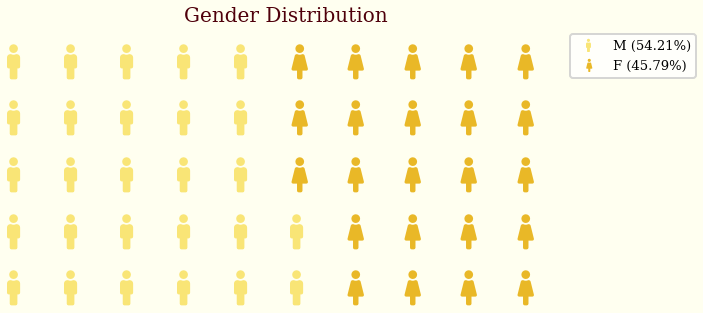

In [15]:
gender_count = train_df["gender"].value_counts()
gender_df = pd.DataFrame (gender_count)
gender_df['percent'] = (gender_df['gender'] /gender_df['gender'].sum()) * 100

fig = plt.figure(
    FigureClass=Waffle, 
    rows=5,
    columns=10,
    values=gender_df['percent'],
    colors = (pink[-1], pink[-2]),
    title={'label': 'Gender Distribution', 'loc': 'center','color':red[0],'size':20},
    labels=[f"{k} ({'{:.2f}'.format(v)}%)" for k, v in zip(gender_df.index, gender_df.percent)],
    legend={'loc': 'upper left', 'bbox_to_anchor': (1,1)},
    icons = ['male','female'],
    icon_legend=True,
    font_size=35, 
    figsize=(10, 8)
)

fig.set_facecolor('#fffff0')
plt.show()

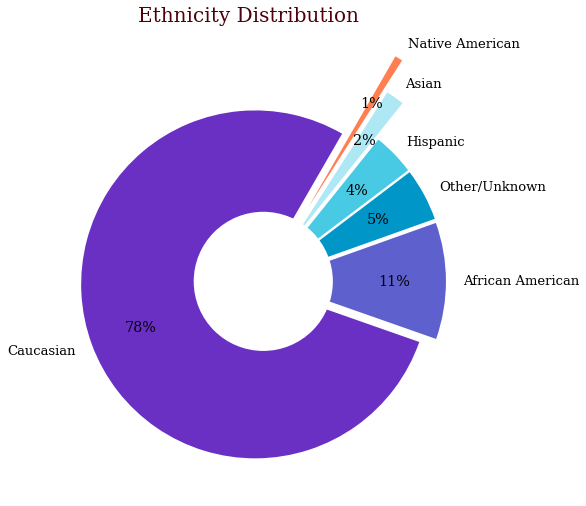

In [16]:
fig, ax  = plt.subplots(figsize=(16, 8))
fig.suptitle('Ethnicity Distribution', size = 20, color = red[0])
explode = (0.05, 0.05, 0.05, 0.05, 0.3, 0.5)
labels = ["Caucasian","African American","Other/Unknown","Hispanic","Asian","Native American"]
sizes = train_df["ethnicity"].value_counts()
ax.pie(sizes, explode=explode, colors=bo, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.7)
ax.add_artist(plt.Circle((0,0),0.4,fc='white'))
plt.show()

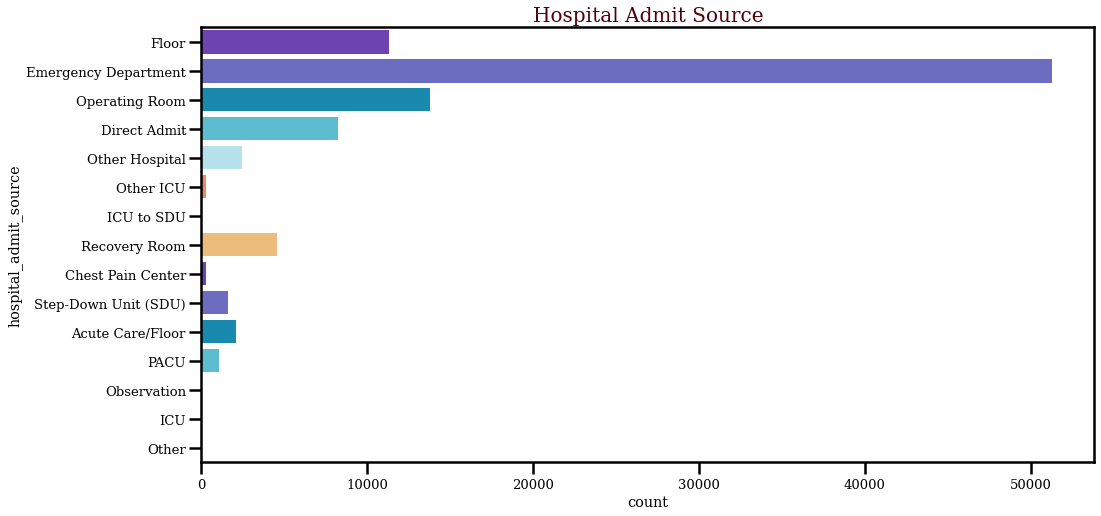

In [17]:
plt.figure(figsize = (16,8))
plt.title('Hospital Admit Source', size = 20, color = red[0])
sns.countplot(y ='hospital_admit_source', data = train_df,palette=bo);

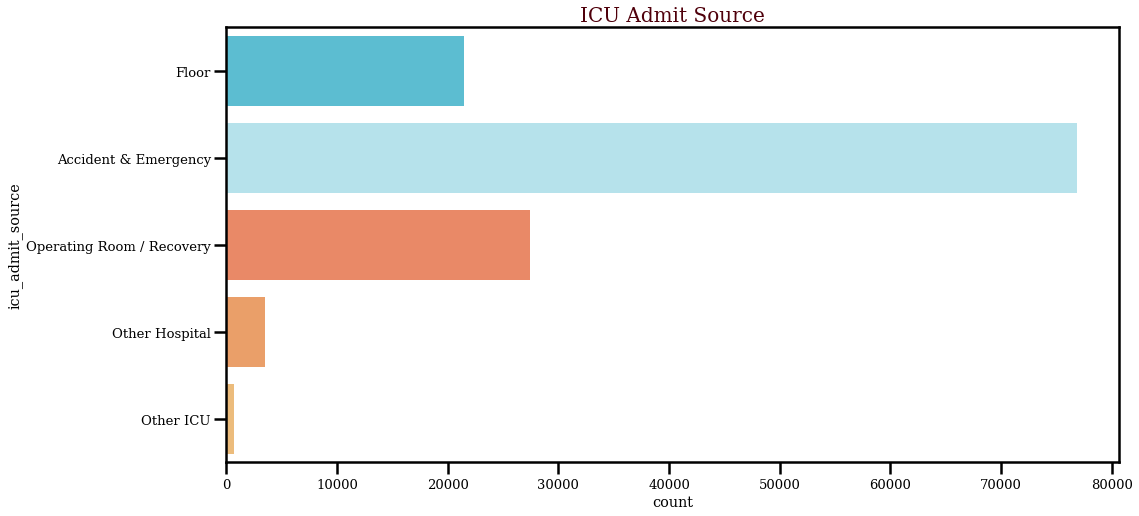

In [18]:
plt.figure(figsize = (16,8))
plt.title('ICU Admit Source', size = 20, color = red[0])
sns.countplot(y ='icu_admit_source', data = train_df,palette=bo[3:]); 

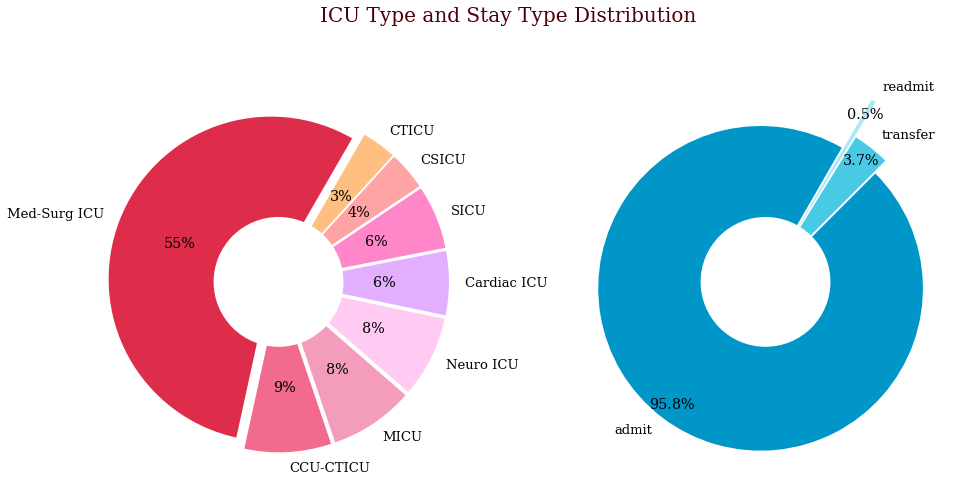

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('ICU Type and Stay Type Distribution', size = 20, color = red[0])
axs = [ax1, ax2]

explode = (0.05, 0.05,0.05, 0.05,0.05, 0.05,0.05, 0.05)
labels = ['Med-Surg ICU', 'CCU-CTICU', 'MICU','Neuro ICU', 'Cardiac ICU', 'SICU','CSICU','CTICU']
sizes = train_df['icu_type'].value_counts()
ax1.pie(sizes, explode=explode, colors=pink[1:], startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.6)
ax1.add_artist(plt.Circle((0,0),0.4,fc='white'))

explode = (0.05, 0.05, 0.3)
labels = ['admit','transfer', 'readmit']
sizes = train_df['icu_stay_type'].value_counts()
ax2.pie(sizes, explode=explode, colors=bo[2:], startangle=60, labels=labels,autopct='%1.1f%%', pctdistance=0.9)
ax2.add_artist(plt.Circle((0,0),0.4,fc='white'))

plt.show()

<div style="background-color:#fae1dd; color:black;">
    <h3><center>Numerical columns</center></h3>
</div>

In [20]:
def hist(col,title):
    
    plt.figure(figsize = (10,8))
    
    ax = sns.distplot(col,kde=False);
    
    values = np.array([patch.get_height() for patch in ax.patches])
    
    #normalizing the values to get a range of colours
    norm = plt.Normalize(values.min(), values.max())
    
    #range of colours from colourmap-rainbow
    colors = plt.cm.rainbow(norm(values))
    
    #set colour for each patch
    for patch, color in zip(ax.patches, colors):
        patch.set_color(color)

    plt.title(title, size = 20, color = red[0])

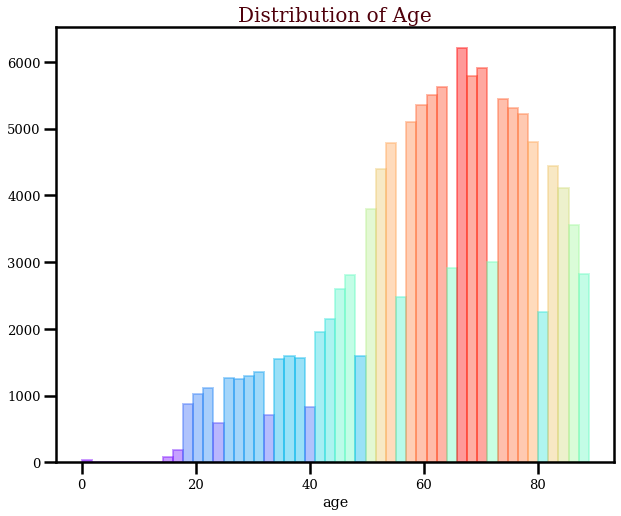

In [21]:
hist(train_df['age'],'Distribution of Age')

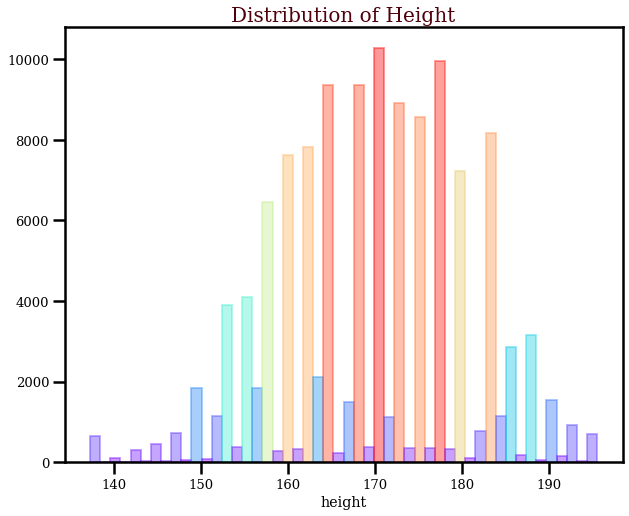

In [22]:
hist(train_df['height'],'Distribution of Height')

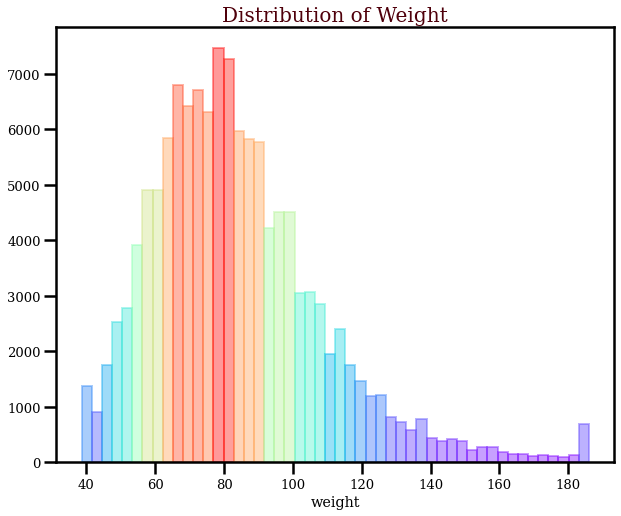

In [23]:
hist(train_df['weight'],'Distribution of Weight')

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/e9/Body_mass_index_chart.svg/1200px-Body_mass_index_chart.svg.png">

Using values from the above [image](https://en.wikipedia.org/wiki/Overweight) as a point of reference for specifying bmi range.

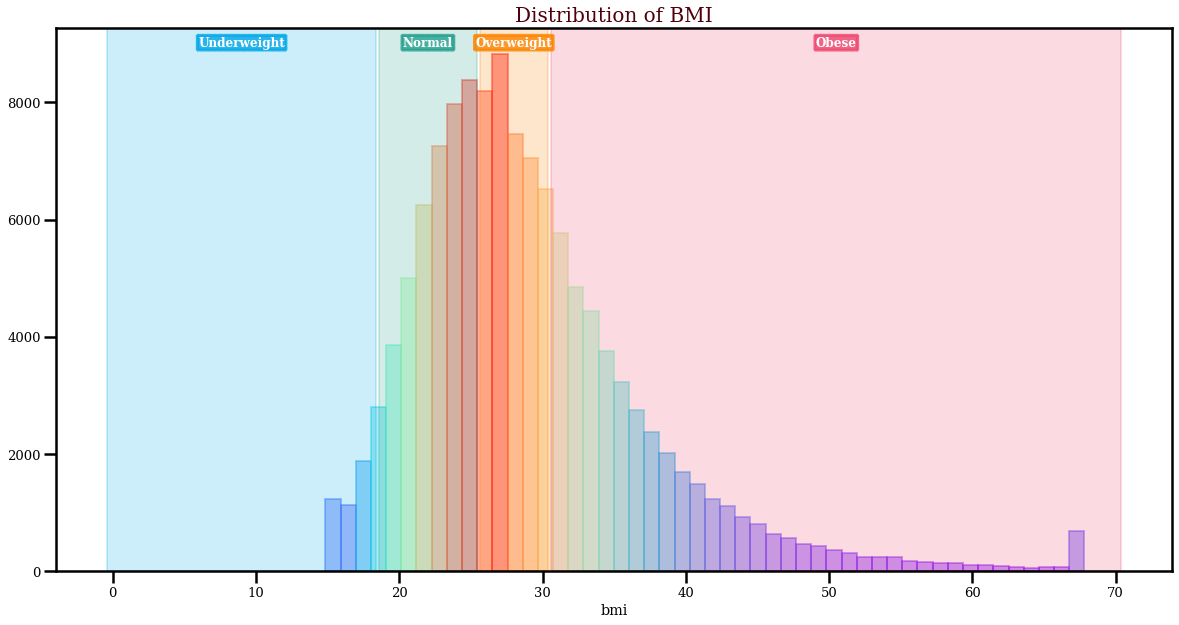

In [24]:
fig, ax = plt.subplots(1,1, figsize=(20, 10))
ax = sns.distplot(train_df['bmi'], kde=False);
values = np.array([patch.get_height() for patch in ax.patches])
norm = plt.Normalize(values.min(), values.max())
colors = plt.cm.rainbow(norm(values))
for patch, color in zip(ax.patches, colors):
        patch.set_color(color)

#colours for different bmi categories
span_color =  ['#00a8e8','#25a18e','#fb8500','#ef476f']

#range of values for different bmi categories
span_range = [[0,18], [19,25], [26,30], [31,70]]

for idx, span_title in enumerate(['Underweight', 'Normal', 'Overweight', 'Obese']):
    ax.annotate(span_title,
                    xy=(sum(span_range[idx])/2 ,1000),
                    xytext=(0,470), textcoords='offset points',
                    va="center", ha="center",
                    color="w", fontsize=10, fontweight='bold',
                    size=12,
                    bbox=dict(boxstyle='sawtooth', pad=0.1, color=span_color[idx], alpha=0.8))
    ax.axvspan(span_range[idx][0]-0.4,span_range[idx][1]+0.4,  color=span_color[idx], alpha=0.2)
plt.title("Distribution of BMI", size = 20, color = red[0])
plt.show()

<p><mark>
Encounter ID, Hospital ID and ICU ID are unique identifiers associated with a patient unit stay, the hospital they were admitted in and the ICU number respectively. Since these are specifically created for the sole purpose of identification, these needn't be included for the model creation. <br><br>
Elective surgery in people with uncontrolled diabetes should preferably be scheduled after acceptable glycemic control has been achieved. We can see a significant drop in the following graph.
</mark></p>

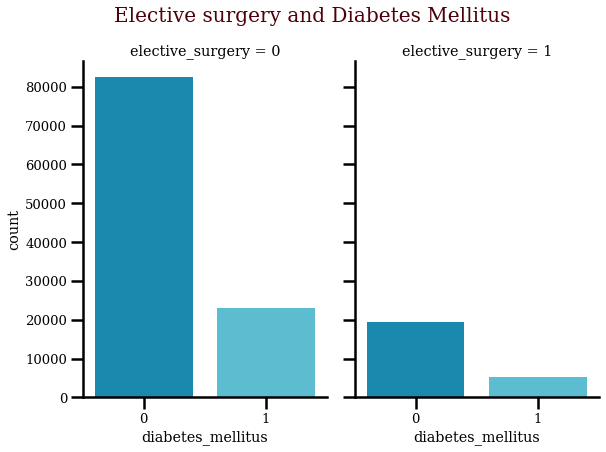

In [25]:
plot = sns.catplot("diabetes_mellitus", col="elective_surgery",data=train_df,kind="count", height=6,aspect=.7,palette=bo[2:]);
plot.fig.suptitle("Elective surgery and Diabetes Mellitus", size = 20, color = red[0], y=1.05);

<p><mark>
Reducing readmission rates of diabetic patients has the potential to greatly reduce health care costs while simultaneously improving care. 
</mark></p>

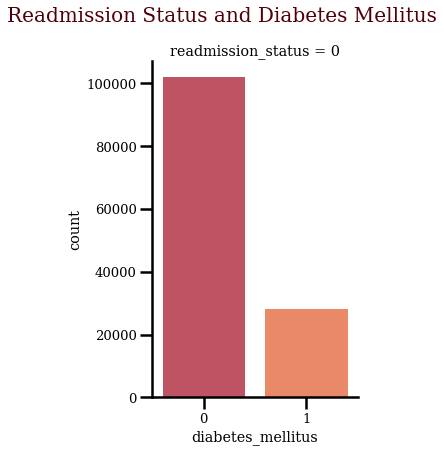

In [26]:
plot = sns.catplot("diabetes_mellitus", col="readmission_status", data=train_df,kind="count", height=6,aspect=.7,palette=red[2:])
plot.fig.suptitle("Readmission Status and Diabetes Mellitus", size = 20, color = red[0], y=1.05);

<p><mark>
APACHE (acute physiology and chronic health evaluation) severity-of-illness classification system is a measure for describing groups of intensive care unit (ICU) patients and evaluating their care. 
</mark></p>

* 1 represents post operative
* 0 represents non operative

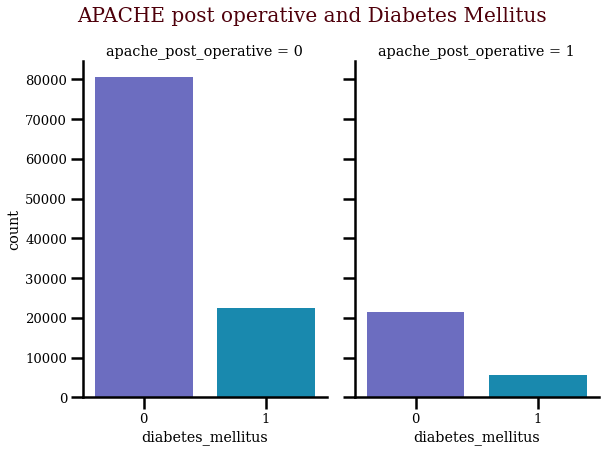

In [27]:
plot = sns.catplot("diabetes_mellitus", col="apache_post_operative", data=train_df,kind="count", height=6,aspect=.7,palette=bo[1:]);
plot.fig.suptitle("APACHE post operative and Diabetes Mellitus", size = 20, color = red[0], y=1.05);

<p><mark>
Used a new library called PyComp for the following viz 🎨
</mark></p>

[Documentation](https://pypi.org/project/pycomp/)

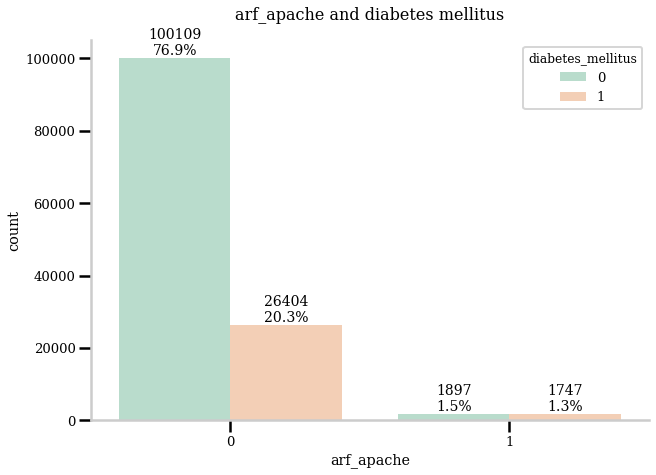

In [28]:
plot_countplot(df=train_df, col='arf_apache', hue='diabetes_mellitus', palette="Pastel2",
                   title='arf_apache and diabetes mellitus')

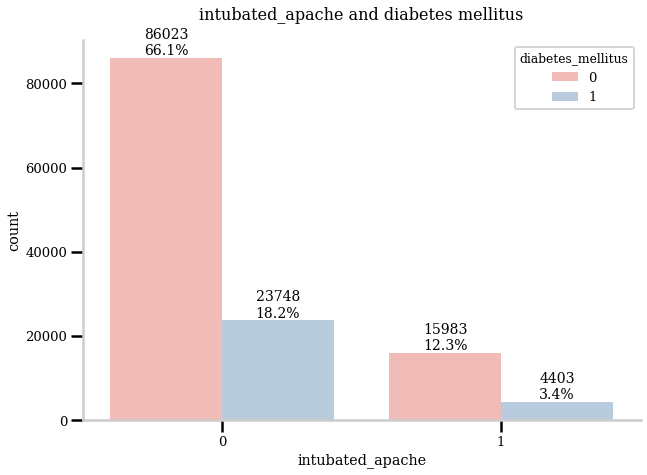

In [29]:
plot_countplot(df=train_df, col='intubated_apache', hue='diabetes_mellitus', palette="Pastel1",
                   title='intubated_apache and diabetes mellitus')

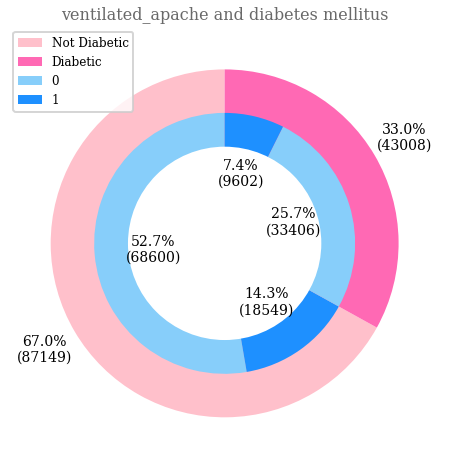

In [30]:
d_map = {1: 'Diabetic', 0: 'Not Diabetic'}
plot_double_donut_chart(df=train_df, col1='ventilated_apache', col2='diabetes_mellitus', label_names_col1=d_map, 
                        colors1=['pink', 'hotpink'], colors2=['lightskyblue','dodgerblue'],
                        title="ventilated_apache and diabetes mellitus")

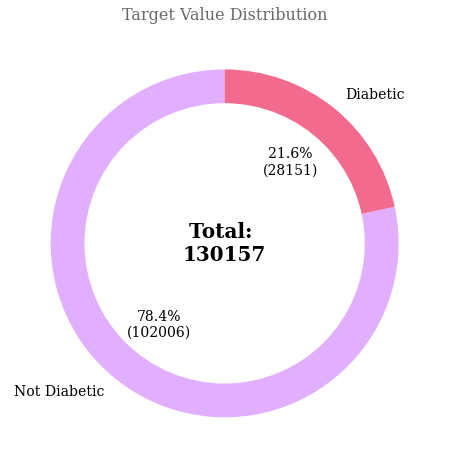

In [31]:
plot_donut_chart(df=train_df, col='diabetes_mellitus', label_names=d_map, colors=[pink[5],pink[2]],
                 title='Target Value Distribution')

In [32]:
def plot_pie(col,cin) :
    diabetes_yes = train_df[(train_df['diabetes_mellitus'] != 0)]
    diabetes_no = train_df[(train_df['diabetes_mellitus'] == 0)]
    
    trace1 = go.Pie(values  = diabetes_yes[col].value_counts().values.tolist(),
                    labels  = diabetes_yes[col].value_counts().keys().tolist(),
                    textfont=dict(size=13), opacity = 0.7,
                    hole = 0.7, 
                    hoverinfo = "label+percent+name",
                    domain  = dict(x = [.0,.48]),
                    name    = "Diabetic",
                    marker  = dict(colors = pink[cin:], line = dict(width = 1.5)))
    trace2 = go.Pie(values  = diabetes_no[col].value_counts().values.tolist(),
                    labels  = diabetes_no[col].value_counts().keys().tolist(),
                    textfont=dict(size=13), opacity = 0.7,
                    hole = 0.7,
                    hoverinfo = "label+percent+name",
                    marker  = dict(line = dict(width = 1.5)),
                    domain  = dict(x = [.52,1]),
                    name    = "Not Diabetic" )

    layout = go.Layout(dict(title = col + " and diabetes mellitus",title_x=0.5,title_font_color=red[0]),
                       annotations = [ dict(text = "Diabetic",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .22, y = -0.1),
                                       dict(text = "Not Diabetic",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .8,y = -.1)])

    fig  = go.Figure(data = [trace1,trace2],layout = layout)
    
    fig.update_layout(legend=dict(  yanchor="top",
                                    y=0.99,
                                    xanchor="left",
                                    x=0.01))
    
    fig.show()

In [33]:
s = dt_i[9:-1] 
cin = 2
for i in s: 
    plot_pie(i,cin)
    cin+=1

In [34]:
dt_fl.append("diabetes_mellitus")

#correlation between features
train_df[np.intersect1d(train_df.columns, dt_fl)].corr().style.background_gradient(cmap='Oranges')

In [35]:
dt_fl.remove("diabetes_mellitus")
dt_i.remove("diabetes_mellitus")

<div style="background-color:#fae1dd; color:black;">
    <h3><center>Handling missing values</center></h3>
</div>

In [36]:
train_df = cudf.DataFrame.from_pandas(train_df)
test_df = cudf.DataFrame.from_pandas(test_df)

In [37]:
train_df[dt_o].isna().sum()

ethnicity                 1587
gender                      66
hospital_admit_source    33198
icu_admit_source           240
icu_stay_type                0
icu_type                     0
dtype: uint64

In [38]:
train_df[dt_o] = train_df[dt_o].fillna("")
train_df[dt_o].isna().sum()

ethnicity                0
gender                   0
hospital_admit_source    0
icu_admit_source         0
icu_stay_type            0
icu_type                 0
dtype: uint64

In [39]:
test_df[dt_o].isna().sum()

ethnicity                 204
gender                      5
hospital_admit_source    2733
icu_admit_source           25
icu_stay_type               0
icu_type                    0
dtype: uint64

In [40]:
test_df[dt_o] = test_df[dt_o].fillna("")
test_df[dt_o].isna().sum()

ethnicity                0
gender                   0
hospital_admit_source    0
icu_admit_source         0
icu_stay_type            0
icu_type                 0
dtype: uint64

In [41]:
train_df[dt_i] = train_df[dt_i].fillna(value=0)
test_df[dt_i] = test_df[dt_i].fillna(value=0)

train_df[dt_fl] = train_df[dt_fl].fillna(value=0)
test_df[dt_fl] = test_df[dt_fl].fillna(value=0)

<div style="background-color:#fae1dd; color:black;">
    <h3><center>Target encoding</center></h3>
</div>

In [42]:
%%time
SMOOTH = 0.001
SPLIT = 'interleaved'
FOLDS = 5

encoder = TargetEncoder(n_folds=FOLDS, smooth=SMOOTH, split_method=SPLIT)

CPU times: user 25 µs, sys: 0 ns, total: 25 µs
Wall time: 29.1 µs


In [43]:
ID_col = ['encounter_id','hospital_id','icu_id']
train_df = train_df.drop(columns=ID_col)
test_df = test_df.drop(columns=ID_col)

In [44]:
%%time
X = train_df.drop(["diabetes_mellitus"],axis=1)
y = train_df["diabetes_mellitus"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    shuffle=False, stratify=y)
for col in dt_o:
    X_train[col] = encoder.fit_transform(X_train[col],y_train)
    X_test[col] = encoder.transform(X_test[col])
    test_df[col] = encoder.transform(test_df[col])

CPU times: user 5.59 s, sys: 74 ms, total: 5.67 s
Wall time: 5.92 s


<div style="background-color:#fae1dd; color:black;">
    <h3><center>Modeling</center></h3>
</div>

In [45]:
def training(model, X_train, y_train, X_test, y_test, model_name):
    t1 = time.time()
    
    model.fit(X_train, y_train)
    predicts = model.predict(X_test)
    roc = ras(y_test, predicts)
    
    t2 = time.time()
    training_time = t2-t1 
    
    print("\t\t\t--- Model:", model_name,"---")
    print("ROC: ", roc,"\t\t\t","Training time:",training_time,"\n")

In [46]:
#cuml-ridge 
ridge = Ridge(fit_intercept = True, normalize = False,solver = "eig")

#cuml-support vector regression
svr = SVR(kernel='rbf', gamma='scale', C=1, epsilon=0.3)

#cuml-KNeighborsClassifier
knc =  KNeighborsClassifier(n_neighbors=3)

m = [ridge,svr,knc]
mn = ["Ridge","SVR","K Neighbors Classifier"]

for i in range(0,len(m)):
    training(model=m[i], X_train=X_train, y_train=y_train, X_test=X_test,y_test=y_test, model_name=mn[i])

			--- Model: Ridge ---
ROC:  0.8218971490859985 			 Training time: 9.487304210662842 

			--- Model: SVR ---
ROC:  0.8111808896064758 			 Training time: 7.565057039260864 

			--- Model: K Neighbors Classifier ---
ROC:  0.6049053072929382 			 Training time: 4.102508306503296 



<div style="background-color:#fae1dd; color:black;">
    <h3><center>XGBoost Model</center></h3>
</div>

<center><img src="https://www.dataapplab.com/wp-content/uploads/2017/08/xgboost.png" height=250 width=250></center>

In [47]:
Xtrain_pd = X_train.to_pandas()
ytrain_pd = y_train.to_pandas()

Xtest_pd = X_test.to_pandas()
ytest_pd = y_test.to_pandas()

In [48]:
dtrain = xgboost.DMatrix(X_train,y_train)
dval   = xgboost.DMatrix(X_test, y_test)
dtest  = xgboost.DMatrix(test_df)

params1 = {'tree_method' : 'gpu_hist','max_depth' : 7,'max_leaves' : 15,'objective' : 'binary:logistic','grow_policy' : 'lossguide','predictor':'gpu_predictor','eta' : 0.7,'eval_metric':'auc'}
evallist = [(dval, 'validation'), (dtrain, 'train')]
num_round=50

In [49]:
%%time

model1 = xgboost.train(params1, dtrain,num_round,evallist)

predicts = model1.predict(xgboost.DMatrix(X_test))
roc = ras(y_test, predicts)
roc

[0]	validation-auc:0.78446	train-auc:0.80127
[1]	validation-auc:0.80277	train-auc:0.81830
[2]	validation-auc:0.80944	train-auc:0.82732
[3]	validation-auc:0.81571	train-auc:0.83354
[4]	validation-auc:0.81799	train-auc:0.83831
[5]	validation-auc:0.82354	train-auc:0.84253
[6]	validation-auc:0.82471	train-auc:0.84518
[7]	validation-auc:0.82634	train-auc:0.84768
[8]	validation-auc:0.82749	train-auc:0.85011
[9]	validation-auc:0.82831	train-auc:0.85211
[10]	validation-auc:0.82909	train-auc:0.85381
[11]	validation-auc:0.83055	train-auc:0.85530
[12]	validation-auc:0.83170	train-auc:0.85643
[13]	validation-auc:0.83175	train-auc:0.85776
[14]	validation-auc:0.83232	train-auc:0.85898
[15]	validation-auc:0.83299	train-auc:0.86019
[16]	validation-auc:0.83259	train-auc:0.86130
[17]	validation-auc:0.83307	train-auc:0.86233
[18]	validation-auc:0.83334	train-auc:0.86339
[19]	validation-auc:0.83364	train-auc:0.86433
[20]	validation-auc:0.83363	train-auc:0.86517
[21]	validation-auc:0.83357	train-auc:0.8659

0.8326956033706665

In [50]:
cu_score = accuracy_score(y_test, predicts)
cu_score

0.8045176267623901

In [51]:
preds1 = model1.predict(xgboost.DMatrix(test_df))

<div style="background-color:#fae1dd; color:black;">
    <h3><center>LightGBM Model</center></h3>
</div>

<center><img src="https://lightgbm.readthedocs.io/en/latest/_images/LightGBM_logo_black_text.svg" height=250 width=250></center>

-- Fold: 0 --
Training until validation scores don't improve for 100 rounds
[250]	valid_0's auc: 0.855085	valid_1's auc: 0.848053
[500]	valid_0's auc: 0.867159	valid_1's auc: 0.853489
[750]	valid_0's auc: 0.874849	valid_1's auc: 0.855338
[1000]	valid_0's auc: 0.881121	valid_1's auc: 0.856158
[1250]	valid_0's auc: 0.886671	valid_1's auc: 0.856695
[1500]	valid_0's auc: 0.891693	valid_1's auc: 0.857001
[1750]	valid_0's auc: 0.896312	valid_1's auc: 0.857077
Early stopping, best iteration is:
[1669]	valid_0's auc: 0.894831	valid_1's auc: 0.857206
-- Fold: 1 --
Training until validation scores don't improve for 100 rounds
[250]	valid_0's auc: 0.855808	valid_1's auc: 0.846121
[500]	valid_0's auc: 0.867265	valid_1's auc: 0.85135
[750]	valid_0's auc: 0.874946	valid_1's auc: 0.853301
[1000]	valid_0's auc: 0.881132	valid_1's auc: 0.854062
[1250]	valid_0's auc: 0.886671	valid_1's auc: 0.854478
[1500]	valid_0's auc: 0.891652	valid_1's auc: 0.854736
Early stopping, best iteration is:
[1529]	valid_0'

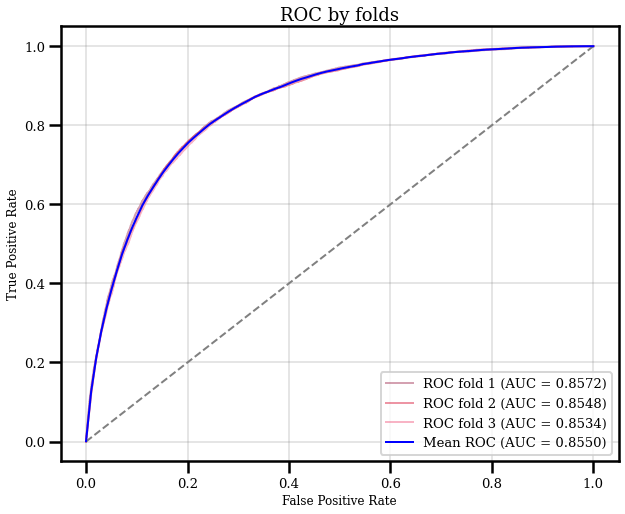

CPU times: user 5min 53s, sys: 1.55 s, total: 5min 55s
Wall time: 3min 8s


In [52]:
%%time

model2 = LGBMClassifier(**{'learning_rate': 0.05,
                    'max_depth': 3,
                    'reg_alpha': 1,
                    'reg_lambda': 1,
                    'objective': 'binary',
                    'metric': 'auc',
                    'n_jobs': -1,
                    'n_estimators' : 5000,
                    'feature_fraction_seed': 42,
                    'bagging_seed': 42,
                    'boosting_type': 'gbdt',
                    'is_unbalance': True,
                    'boost_from_average': False})

plt.rcParams['figure.figsize']=(10,8)
    
tprs = []
aucs = []
roc_aucs = []
mean_tpr = []
mean_fpr = []

X_c = pd.concat([Xtrain_pd, Xtest_pd])
y_c = pd.concat([ytrain_pd, ytest_pd])

oof = np.zeros(len(X_c))
mean_fpr = np.linspace(0,1,100)

i = 1

folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=2021)

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_c,y_c)):
    print('-- Fold:', fold_,'--' )
    model2 = model2.fit(X_c.iloc[trn_idx], y_c.iloc[trn_idx], categorical_feature=dt_o, eval_set=[(X_c.iloc[trn_idx],y_c.iloc[trn_idx]),(X_c.iloc[val_idx], y_c.iloc[val_idx])],
                          eval_metric = 'auc',
                          early_stopping_rounds = 100,verbose=250)
        
    oof[val_idx] =  model2.predict_proba(X_c.iloc[val_idx])[:,1]
        
    f = plt.figure(1)
    fpr, tpr, t = roc_curve(y_c[val_idx], oof[val_idx])
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.5, label='ROC fold %d (AUC = %0.4f)' % (i,roc_auc))
    roc_aucs.append(roc_auc_score(y_c[val_idx], oof[val_idx]))
    i+=1

print('\nCV ROC        : {0:.4f}, std: {1:.4f}.'.format(np.mean(roc_aucs), np.std(roc_aucs)))

plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'grey')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
             label=r'Mean ROC (AUC = %0.4f)' % ((mean_auc)),lw=2, alpha=1)
plt.grid(b=True, which='major', color='grey', linewidth=0.4)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC by folds', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [53]:
preds2 = model2.predict_proba(test_df.to_pandas())[:,1]
preds2

array([0.13966544, 0.41491293, 0.38743421, ..., 0.2810246 , 0.03331941,
       0.04283874])

In [54]:
preds3 = ridge.predict(test_df).to_array()
preds3

array([-0.0297813 ,  0.03244835,  0.02270226, ...,  0.17971867,
        0.0248595 ,  0.01207337])

<div style="background-color:#fae1dd; color:black;">
    <h3><center>Feature Importance: XGB</center></h3>
</div>

In [55]:
def feature_imp(model):
    explainer = shap.TreeExplainer(model1)
    shap_values = explainer.shap_values(Xtest_pd)
    
    #summary plots
    shap.summary_plot(shap_values, Xtest_pd, plot_type="bar",color=pink[5])

    shap.summary_plot(shap_values, Xtest_pd)
    
    #dependence plots
    shap.dependence_plot("d1_glucose_max", shap_values, Xtest_pd)

    shap.dependence_plot("bmi", shap_values, Xtest_pd)

    shap.dependence_plot("age", shap_values, Xtest_pd)

    shap.dependence_plot("glucose_apache", shap_values, Xtest_pd)

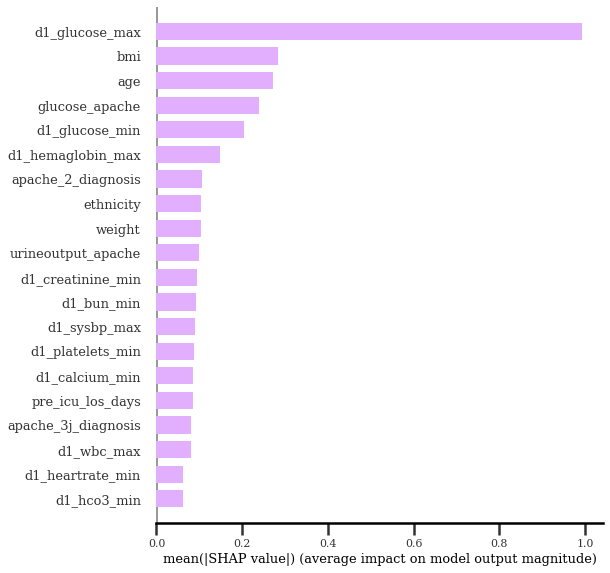

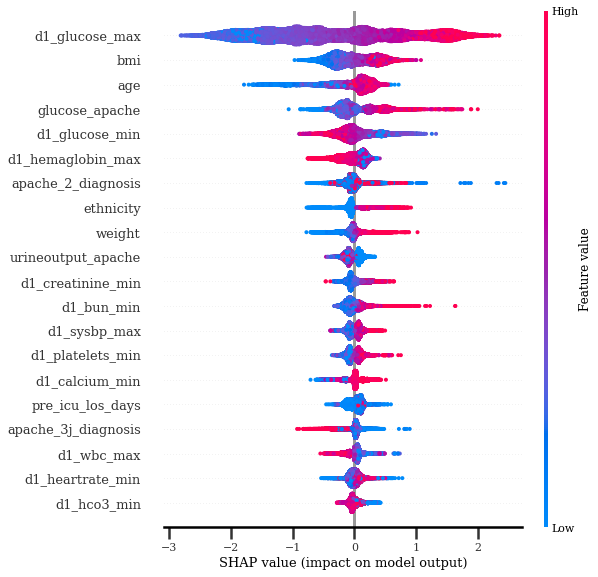

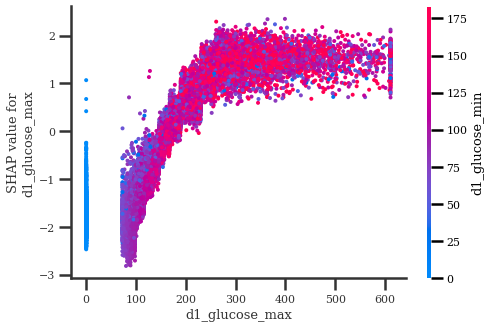

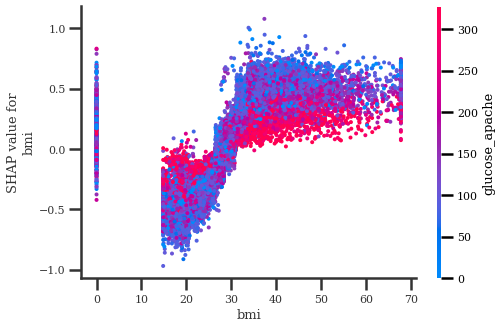

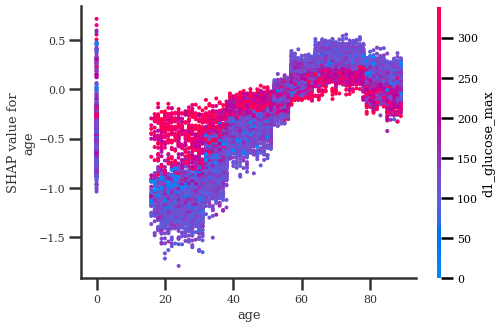

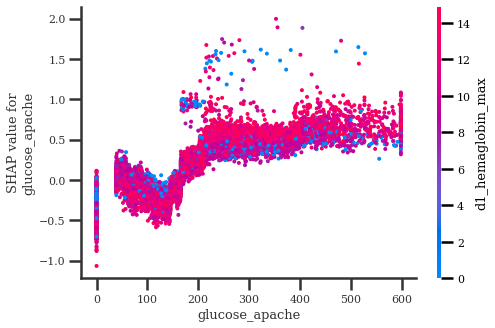

CPU times: user 31.1 s, sys: 134 ms, total: 31.2 s
Wall time: 31.2 s


In [56]:
%%time
feature_imp(model1)

<div style="background-color:#fae1dd; color:black;">
    <h3><center>Creating the submission file</center></h3>
</div>

In [57]:
#blending predictions from various models
blended_preds = 0.7*preds2 + 0.2*preds1 + 0.1*preds3

In [58]:
encounter_IDs = cudf.read_csv("../input/widsdatathon2021/UnlabeledWiDS2021.csv")[["encounter_id"]].values

In [59]:
df_sub = {'encounter_id': encounter_IDs, 'diabetes_mellitus': blended_preds}
df_predictions = cudf.DataFrame(df_sub).set_index(['encounter_id'])
df_predictions.head(10)

diabetes_mellitus
encounter_id                   
144740                 0.097432
141990                 0.331371
142038                 0.290827
138628                 0.113324
141682                 0.340948
139096                 0.227650
142994                 0.696478
141954                 0.136573
135344                 0.733764
142552                 0.817352

In [60]:
df_predictions.to_csv('/kaggle/working/Predictions_blended.csv')

Inspiration:
- [Simple Matplotlib & Visualization Tips 💡](https://www.kaggle.com/subinium/simple-matplotlib-visualization-tips)

Illustrations tools:
- [Canva](https://www.canva.com/en_gb/) 🖌️
- [Storyset](https://storyset.com/) 🖼️

<div>
    <img src="https://i.imgur.com/pl3FhXV.png">
</div>